<a href="https://colab.research.google.com/github/s83512266/Tibame_AI_111-2_group2_project/blob/main/Transfer_learning_5_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt # seaborn
from PIL import Image

import os # file path
from glob import glob # search files
from tqdm.auto import tqdm # progress bar

import tensorflow as tf
from tensorflow.keras import layers, models, utils

from sklearn.model_selection import train_test_split

# **Read one image**

In [ ]:
IMG_SIZE = 256 # 256 128 64

all_class = ['MD_Normal', 'MD_old_water', 'MD_sunburnt', 'MD_bac_fungi', 'Others']
class_map = {cls: i for i, cls in enumerate(all_class)} 
#  'MD_Normal':0, 'MD_old_water':1, 'MD_sunburnt':2, 'MD_bac_fungi':3, 'Others':4
class_map

{'MD_Normal': 0,
 'MD_old_water': 1,
 'MD_sunburnt': 2,
 'MD_bac_fungi': 3,
 'Others': 4}

In [ ]:
MD_path = glob("/content/drive/MyDrive/圖片/(a.b) 正常龜背芋/train/*.jpg")
MD_old_water_path = glob("/content/drive/MyDrive/圖片/(c.e.f) 老化、水和空氣/train/*.jpg")
MD_sunburnt_path = glob("/content/drive/MyDrive/圖片/(d)曬傷/train/*.jpg")
MD_bac_fungi_path = glob("/content/drive/MyDrive/圖片/(g.h)真菌/train/*.jpg")
Others_path = glob("/content/drive/MyDrive/圖片/(i)非龜背芋種/train/*.jpg")

img_paths = MD_path + MD_old_water_path + MD_sunburnt_path + MD_bac_fungi_path + Others_path

# number of images
len(img_paths)

1601

/content/drive/MyDrive/圖片/(c.e.f) 老化、水和空氣/train/69.jpg
(925, 925, 3)


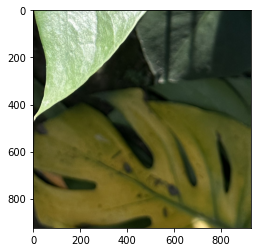

In [ ]:
# show image
path = img_paths[700]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(path)
print(img.shape)
plt.imshow(img)
plt.show()

((925, 925, 3), (256, 256, 3))

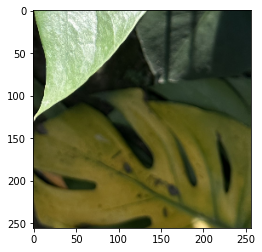

In [ ]:
# Resize  img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
# os.sep: /
print(path)
cls = path.split(os.sep)[-3]
print(cls)

/content/drive/MyDrive/圖片/(c.e.f) 老化、水和空氣/train/69.jpg
(c.e.f) 老化、水和空氣


In [ ]:
# Get file class index for train

# for MD_Normal class
if cls == '(a.b) 正常龜背芋':
    cls_idx = class_map["MD_Normal"]
    print(cls_idx)
# for sick class
elif cls == '(c.e.f) 老化、水和空氣':
    cls_idx = class_map["MD_old_water"]
    print(cls_idx)
elif cls == '(d)曬傷':
    cls_idx = class_map["MD_sunburnt"]
    print(cls_idx)
elif cls == '(g.h)真菌':
    cls_idx = class_map["MD_bac_fungi"]
    print(cls_idx)
# for others class
else:
    cls_idx = class_map["Others"]
    print(cls_idx)

1


# **Read all image**

In [ ]:
def read_data(paths):
    data_count = len(paths)
    x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3)) # model input
    y = np.zeros((data_count, )) # answer

    for i, path in enumerate(tqdm(paths)):
        # read image
        img = cv2.imread(path) # (H, W, 3)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize
        # Normalization
        img = tf.keras.applications.efficientnet_v2.preprocess_input(img, data_format=None)

        # read class index
        cls = path.split(os.sep)[-3]
        
        # for MD_Normal class
        if cls == '(a.b) 正常龜背芋':
            cls_idx = class_map["MD_Normal"]
        # for new_leaf class
        elif cls == '(c.e.f) 老化、水和空氣':
            cls_idx = class_map["MD_old_water"]
        elif cls == '(d)曬傷':
            cls_idx = class_map["MD_sunburnt"]
        elif cls == '(g.h)真菌':
            cls_idx = class_map["MD_bac_fungi"]
        # for others class
        else:
            cls_idx = class_map["Others"]
        
        x[i] = img
        y[i] = cls_idx
    return x, y


In [ ]:
x, y = read_data(img_paths)

  0%|          | 0/1601 [00:00<?, ?it/s]

In [ ]:
x.shape, y.shape

((1601, 256, 256, 3), (1601,))

In [ ]:
from sklearn.model_selection import train_test_split
# split train and test dataset
# 90%x, 10%x, 90%y, 10%y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1440, 256, 256, 3), (161, 256, 256, 3), (1440,), (161,))

In [ ]:
# label count
print(all_class)
# train
unique_classes, counts = np.unique(y_train, return_counts=True)
print(unique_classes, counts)

# test
unique_classes, counts = np.unique(y_test, return_counts=True)
print(unique_classes, counts)

['MD_Normal', 'MD_old_water', 'MD_sunburnt', 'MD_bac_fungi', 'Others']
[0. 1. 2. 3. 4.] [587 126  66  63 598]
[0. 1. 2. 3. 4.] [52 11  3  8 87]


In [ ]:
# one-hot encoding
y_train = utils.to_categorical(y_train, num_classes=len(class_map))
y_test = utils.to_categorical(y_test, num_classes=len(class_map))

In [ ]:
y_train.shape, y_test.shape

((1440, 5), (161, 5))

# **Build model**

In [ ]:
base_model = tf.keras.applications.EfficientNetV2M(include_top=False, 
                          weights='imagenet',
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.GlobalAveragePooling2D()(base_model.output) 
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(5, activation='softmax')(x)

# Freeze layers
for l in base_model.layers:
    l.trainable = False

model = models.Model(base_model.input, x)

214201816/214201816 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# y_train是one-hot encoding，不能使用SparseCategoricalCrossentropy()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/transfer_best_v2.h5", save_best_only=True),
    # subclassed models不能使用ModelCheckpoint存模型
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
    # 當模型連續訓練n次沒有更好，就進行一次學習率衰降。
]

In [ ]:
logs = model.fit(x_train, y_train,
          batch_size=4,
          epochs=500,
          validation_split=0.1,
          callbacks=callbacks
    )

Epoch 1/500
324/324 [==============================] - 51s 83ms/step - loss: 0.8258 - accuracy: 0.6998 - val_loss: 0.5676 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 2/500
324/324 [==============================] - 23s 72ms/step - loss: 0.5170 - accuracy: 0.8148 - val_loss: 0.5018 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 3/500
324/324 [==============================] - 20s 63ms/step - loss: 0.4002 - accuracy: 0.8619 - val_loss: 0.5234 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 4/500
324/324 [==============================] - 19s 59ms/step - loss: 0.3418 - accuracy: 0.8758 - val_loss: 0.5023 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 5/500
324/324 [==============================] - 19s 60ms/step - loss: 0.2367 - accuracy: 0.9105 - val_loss: 0.5347 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 6/500
324/324 [==============================] - 23s 72ms/step - loss: 0.1700 - accuracy: 0.9498 - val_loss: 0.4802 - val_accuracy: 0.8472 - lr: 3.0000e-04
Epoch 7/500
324/324 [===========================

# **Training log**

In [ ]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch+1)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

min_loss_epoch:  6
val loss  0.4801981747150421
val acc 0.8472222089767456


Text(0.5, 1.0, 'accuracy')

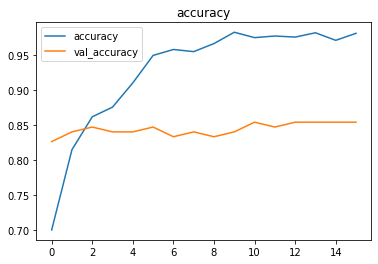

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

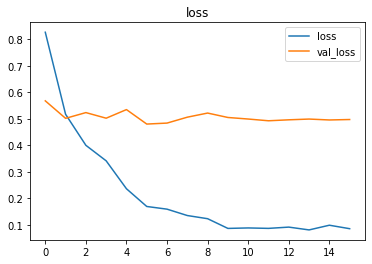

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

# **Evaluate**

In [ ]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 8s 343ms/step - loss: 0.3779 - accuracy: 0.8944


[0.377856582403183, 0.8944099545478821]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(y_test, axis=-1) # [0, 1, 2, ...]

prediction = model.predict(x_test)
y_pred = np.argmax(prediction, axis=-1) # [0, 1, 2, ...]

print(y_true.shape, y_pred.shape)

6/6 [==============================] - 6s 242ms/step
(161,) (161,)


In [ ]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        52
           1       0.64      0.64      0.64        11
           2       0.25      0.33      0.29         3
           3       0.80      0.50      0.62         8
           4       0.97      0.95      0.96        87

    accuracy                           0.89       161
   macro avg       0.71      0.67      0.68       161
weighted avg       0.90      0.89      0.89       161



In [ ]:
import pandas as pd
# Confusion matrix:
#   row: Ground truth
#   column: predict
mat = confusion_matrix(y_true, y_pred)
pd.DataFrame(mat,
      columns=["{}(predict)".format(all_class[i]) for i in range(5)],
      index=["{}(true)".format(all_class[i]) for i in range(5)])

,MD_Normal(predict),MD_old_water(predict),MD_sunburnt(predict),MD_bac_fungi(predict),Others(predict)
MD_Normal(true),49,2,0,0,1
MD_old_water(true),1,7,1,1,1
MD_sunburnt(true),0,1,1,0,1
MD_bac_fungi(true),1,1,2,4,0
Others(true),4,0,0,0,83


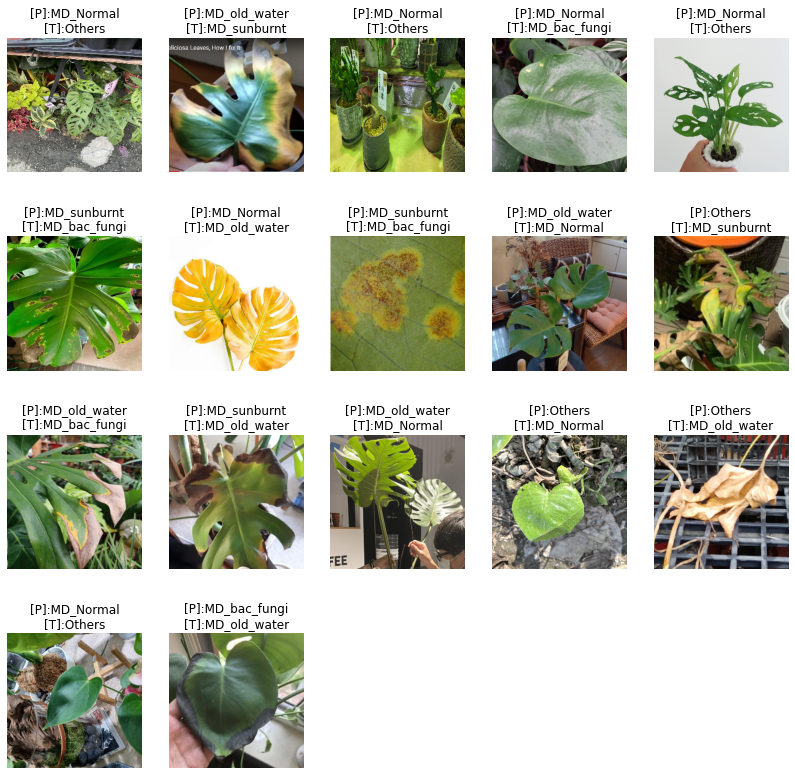

In [ ]:
plt.figure(figsize=(14, 14))

idx = np.nonzero(y_pred != y_true)[0]

false_pre = y_pred[idx]
false_true = y_true[idx]
false_img = x_test[idx]

width = 5
height = len(idx) // width + 1

for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    title = "[P]:{}\n[T]:{}".format(all_class[false_pre[i]], all_class[false_true[i]])
    plt.title(title)
    plt.axis("off")
    for j in range(len(false_img)):
        false_img[j]
    plt.imshow(false_img[i][:, :, ::-1].astype(int))

# **Save model**

In [ ]:
# 1. save whole model and weights
# model.save('/content/drive/MyDrive/my_model.h5')
# 2. save and load weights only
# model.save_weights('/content/drive/MyDrive/CLF_model_weights.h5')

# **Load model**

In [ ]:
# 1. load whole model and weights
# model2 = models.load_model('my_model.h5')
# 2. Rebuild model before load weights !
# model2 = MyModel()
# model2.load_weights('CLF_model_weights.h5')

# **Predict image**

輸入一個網址https://shoplineimg.com/5756526be37ec6ab5e000158/608000a4942e94003f2e8537/2000x.webp?source_format=jpg


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


1/1 [==============================] - 4s 4s/step
Monstera_Deliciosa 的機率: 0.00011196729
Others 的機率: 0.99988806
答案是: Others


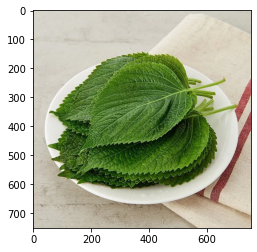

In [ ]:
import requests

url = input("輸入一個網址")
h = {
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
}

response = requests.get(url, stream=True, verify=False, headers=h)
img = Image.open(response.raw)
img_r = img.convert("RGB").resize((256, 256))
img_r = np.array(img_r).reshape(1, 256, 256, 3)
img_r = tf.keras.applications.efficientnet_v2.preprocess_input(img_r, data_format=None)
proba = model.predict(img_r)[0]
for t, p in zip(all_class, proba):
    print(t, "的機率:", p)
ans = all_class[proba.argmax(axis=-1)]
print("答案是:", ans)
plt.imshow(img)